# Сборный проект: Исследование популярного продукта в интернет магазине "Стримчик"

Интернет-магазине `«Стримчик»`  продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о `продажах игр`, `оценки пользователей и экспертов`, `жанры` и `платформы` (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит `сделать ставку на потенциально популярный продукт` и `спланировать рекламные кампании`.<br>
Перед нами данные до 2016 года.<br>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».<br>

**Посмотрим:**<br>
-Cколько игр выпускалось в разные годы;<br>
-Как менялись продажи по платформам; <br>
-Какие платформы лидируют по продажам, растут или падают? <br>
-На общее распределение игр по жанрам. <br>

Составим **портерт пользователя** каждой страны, а также проверим **гипотезы**:<br>
-Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;<br>
-Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm
from scipy import stats as st
import math
from math import factorial
from math import sqrt
import matplotlib as mpl
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

## **Шаг. Откроем файл с данными и изучим общую информацию:**

<i>Всего игр не более 16715. Есть пропуски в столбцах `name`, `year_of_release`, `genre`, `critic_Score`, `user_Score`, `Rating`. Регистр названия столбцов неверный ( если учитывать змеинный стиль). <i>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> Отлично, с данными познакомились!  </div>

## **Шаг . Подготовим данные:**

In [3]:
#Заменим названия столбцов (приведем их к нижнему регистру)
#data = data.rename(columns=lambda x: x.lower())
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> 

Также названия столбцов можно привести в нижнему регистру, если к `df.columns` применить метод `str.lower`</div>

```python

                                    df.columns = df.columns.str.lower()
    
```

**Обработаем пропуски:**

In [4]:
data.isna().sum() #Всего пропусков в каждом столбце

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [5]:
data[data['name'].isnull()] #Пропуски в столбцу name

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


<i>Строк с этими пропусками очень мало, также сразу видно, что это те же строки, где пропущены `genre`, удалим их.<i>

In [6]:
data = data.dropna(subset=['name'])

In [7]:
data['year_of_release'].isnull().sum() #Пропуски в столбце year_of_release, их совсем немного - удалим их, они все равно не попадут в актуальный период

269

In [8]:
data = data.dropna(subset=['year_of_release'])

In [9]:
data['user_score'].unique() 

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [10]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

tbd - Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований.

In [11]:
data['user_score'] = data['user_score'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)
data['rating'] = data['rating'].fillna(-1)

**А вот пропусков в столбцах с рейтингами очень много, эти пропуски не случайные. Заменять их ни -1 и будем это учитывать.**

In [12]:
data.isna().sum() #Проверим, что пропуски обработаны

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

In [13]:
#Преобразуtv данные в нужные типы:
data['year_of_release'] = data['year_of_release'].astype('int') #год всегда целочисленное значение
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1,-1
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1,-1


In [14]:
# код ревьюера
data['critic_score'].sum() == data['critic_score'].astype('int').sum()

True

In [15]:
data['critic_score'] = data['critic_score'].astype('int') #Изменим тип данных на int

In [16]:
data['user_score'] = data['user_score'].astype('float') #оценка пользователя может быть с плавающий точкой в диапазоне от 0 до 10

**Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:**

In [17]:
#data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,31.38


In [18]:
data.duplicated().sum() #Явных дубликатов нет

0

In [19]:
data[data.duplicated(['name', 'platform', 'year_of_release'])] #Поищим неполные дубликаты:

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83,5.5,E,0.01


In [20]:
data = data.drop_duplicates(subset = ['name', 'platform', 'year_of_release']) #Удалим их

array([[<AxesSubplot:title={'center':'year_of_release'}>,
        <AxesSubplot:title={'center':'na_sales'}>,
        <AxesSubplot:title={'center':'eu_sales'}>],
       [<AxesSubplot:title={'center':'jp_sales'}>,
        <AxesSubplot:title={'center':'other_sales'}>,
        <AxesSubplot:title={'center':'critic_score'}>],
       [<AxesSubplot:title={'center':'user_score'}>,
        <AxesSubplot:title={'center':'all_sales'}>, <AxesSubplot:>]],
      dtype=object)

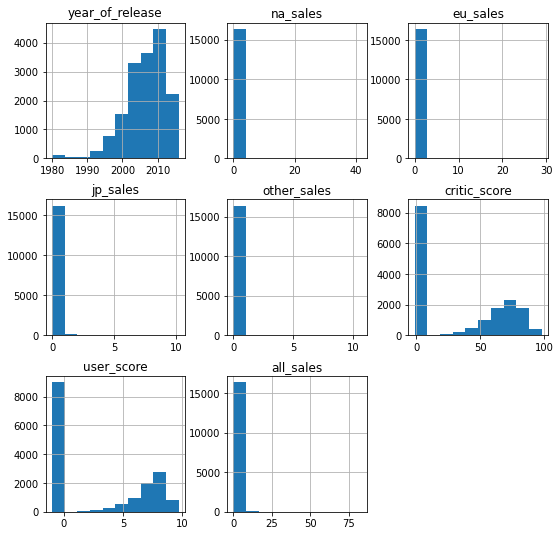

In [21]:
data.hist(figsize=(9,9))

In [22]:
data.info()#Проверим, что типы столбцов изменены, дубликаты убраны

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  all_sales        16443 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


**Вывод шага 1. При обработке данных было сделано:**<br>
-заменен регистр названия столбцов;<br>
-преобразованы данные в нужный типа;<br>
-заполнены все пропуски, удалены некоторые данные с пустыми значениями по столбца года и имени; <br>
-посчитаны суммарные продажи во всех регионах.<br>
Очень много пропущенных данным в рейтингах, скорее всего эти данные не подгружены. Аномалий не замечено на гистограммах.

## **Шаг . Проведем исследовательский анализ данных:**

**Посмотрим на графике, сколько игр выпускалось в разные годы:**

Text(0, 0.5, 'Год')

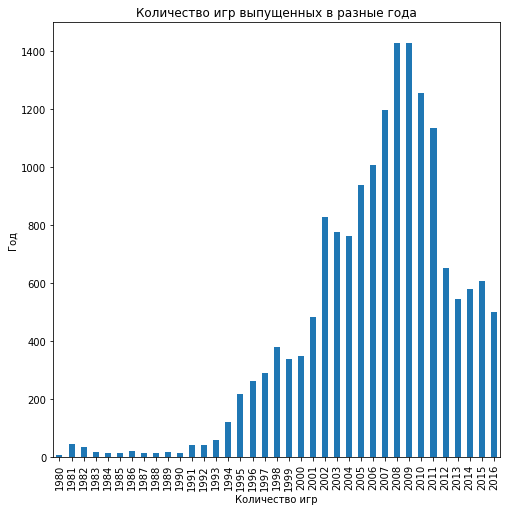

In [23]:
data['year_of_release'].value_counts().sort_index(ascending=True).plot( kind='bar', figsize=(8,8))
plt.title("Количество игр выпущенных в разные года")
plt.xlabel("Количество игр")
plt.ylabel("Год")

<i>Считаю, что за все годы данные важны. Малое количетсво игр в конце 20 века  обуславливается тем, что в то время только начали появлятся различные технические изобретения, в том числе и платформы и игры.<i>

**Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам:**

In [24]:
platform_sales = data.pivot_table(index='platform', values='all_sales', aggfunc='sum')
platform_sales.columns = ['sum_sales']
platform_sales.sort_values(by='sum_sales', ascending=False).head(10)

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


<i>Возьмем первые 6 платформ для анализа: PS2, X360, PS3, Wii, DS, PS.<i>

In [25]:
platform_top6 = data.groupby('platform').agg({'all_sales': 'sum'}).sort_values(by='all_sales', ascending=False).head(6).index.to_list()
platform_top6

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [26]:
data_platform_top6 = data[data['platform'].isin(platform_top6)]
platform_sales_year = data_platform_top6.pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum')
platform_sales_year

all_sales
platform year_of_release           
DS       1985                  0.02
         2004                 17.27
         2005                130.14
         2006                119.81
         2007                146.94
...                             ...
X360     2012                 99.74
         2013                 88.58
         2014                 34.74
         2015                 11.96
         2016                  1.52

[67 rows x 1 columns]

In [27]:
def plot_f(x):#Функция для построения графиков по топ-6 платформ
    platform_sales_year.query("platform == @x").plot(kind='bar', figsize=(3,3))
    plt.title(f"Продажи по годам. Платформа {x}")
    plt.xlabel("Года")
    plt.ylabel("Продажи в млн.")

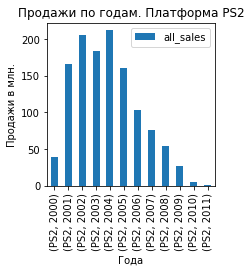

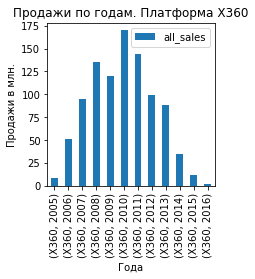

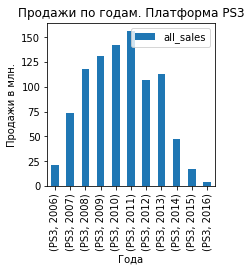

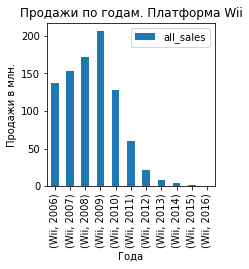

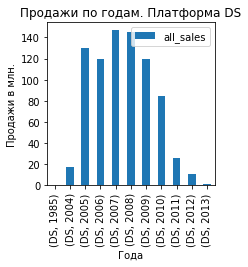

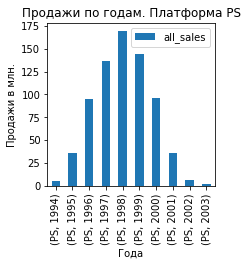

In [28]:
for i in platform_top6:
    plot_f(i)

In [29]:
for i in platform_top6:
    living = data_platform_top6.query('platform == @i')['year_of_release'].max() - data_platform_top6.query('platform == @i ')['year_of_release'].min() + 1
    print(f"Примерный срок жизни плафтормы {i}: {living} лет.")

Примерный срок жизни плафтормы PS2: 12 лет.
Примерный срок жизни плафтормы X360: 12 лет.
Примерный срок жизни плафтормы PS3: 11 лет.
Примерный срок жизни плафтормы Wii: 11 лет.
Примерный срок жизни плафтормы DS: 29 лет.
Примерный срок жизни плафтормы PS: 10 лет.


In [30]:
# код ревьюера
data.groupby('platform')['year_of_release'].nunique().mean() 

7.67741935483871

<i>Средняя продолжительность "жизни" платформы 10 лет. Большенство платформ были популярны в разные года, отсюда и различные временные промежтки. Но можно заметить, что платформа `DS` и `PS2` имели свои пики продаж в одном году, что может говорить о их сильно конкуренции.<i>

**Возьмем данные за 2014 - 2016 год.**

In [31]:
data_actual = data.query('2014 <= year_of_release <= 2016')
platform_sales_year = platform_sales_year.query('2013 <= year_of_release <= 2016')

In [32]:
actual_platform = list(set(data_actual['platform'].unique()))
data_actual_platform = data_actual[data_actual['platform'].isin(actual_platform)]
data_actual_platform_year = data_actual_platform.pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum')
data_actual_platform_year

all_sales
platform year_of_release           
3DS      2014                 43.76
         2015                 27.78
         2016                 15.14
PC       2014                 13.28
         2015                  8.52
         2016                  5.25
PS3      2014                 47.76
         2015                 16.82
         2016                  3.60
PS4      2014                100.00
         2015                118.90
         2016                 69.25
PSP      2014                  0.24
         2015                  0.12
PSV      2014                 11.90
         2015                  6.25
         2016                  4.25
Wii      2014                  3.75
         2015                  1.14
         2016                  0.18
WiiU     2014                 22.03
         2015                 16.35
         2016                  4.60
X360     2014                 34.74
         2015                 11.96
         2016                  1.52
XOne     2014                 54.07
         2015                 60.14
         2016                 26.15

In [33]:
def plot_f2(x):#Функция для построения графиков по плафтормам из актуального периода
    data_actual_platform_year.query("platform == @x").plot(kind='bar', figsize=(3,3))
    plt.title(f"Продажи 2014-2016 г. Платформа {x}")
    plt.xlabel("Года")
    plt.ylabel("Продажи в млн.")

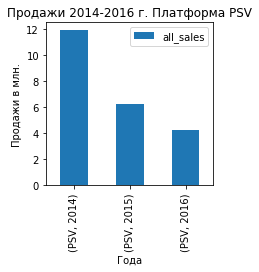

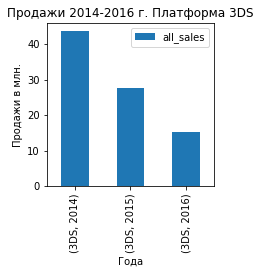

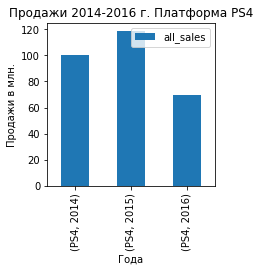

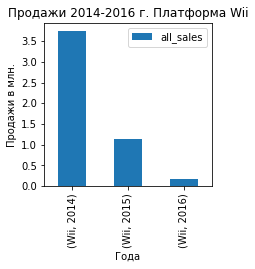

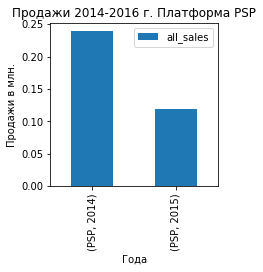

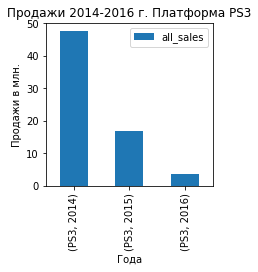

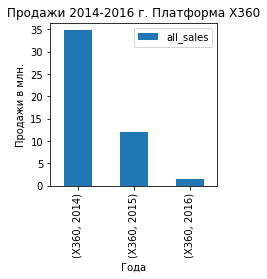

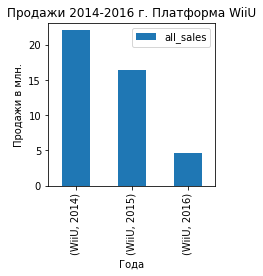

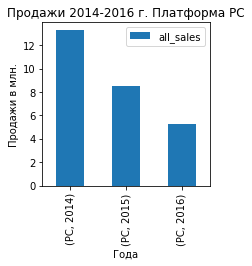

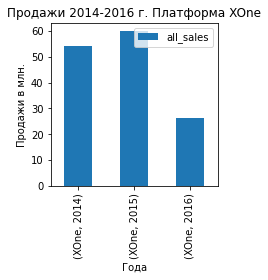

In [34]:
for i in actual_platform:
    plot_f2(i)
   
    

Более потенциально прибыльные платформы: PS4 и XOne. 

**Построим для них график «ящик с усами» по глобальным продажам игр в разбивке по платформам в актуальном периоде:**

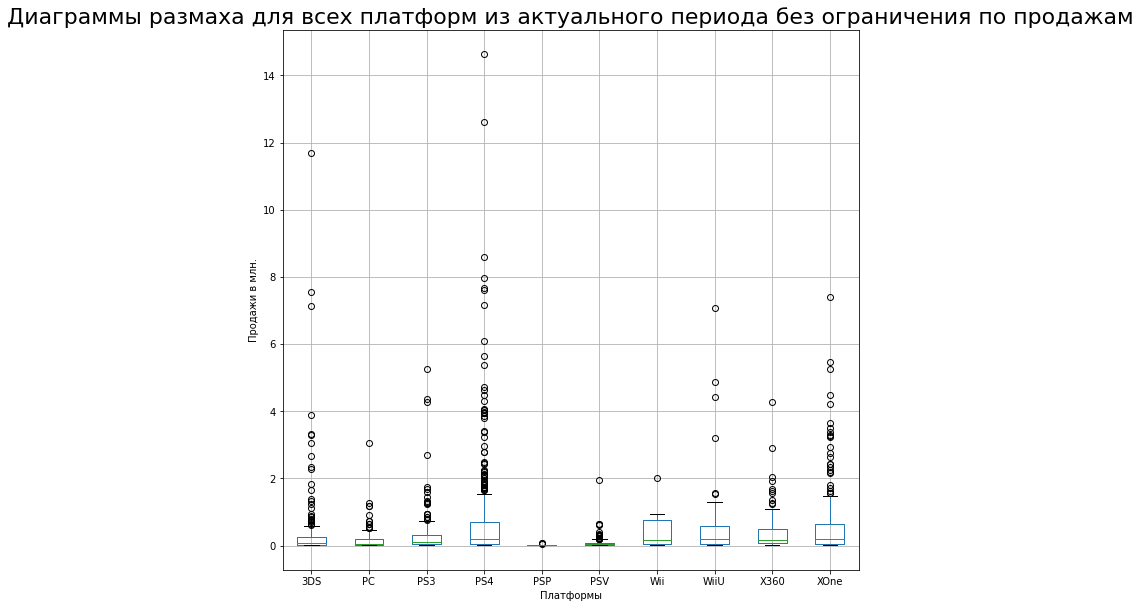

In [35]:
data_actual[['all_sales', 'platform']].boxplot('all_sales', by='platform', figsize=(10,10))
plt.xlabel("Платформы")
plt.ylabel("Продажи в млн.")
plt.suptitle('')
plt.title('Диаграммы размаха для всех платформ из актуального периода без ограничения по продажам', fontsize=22)
plt.show()

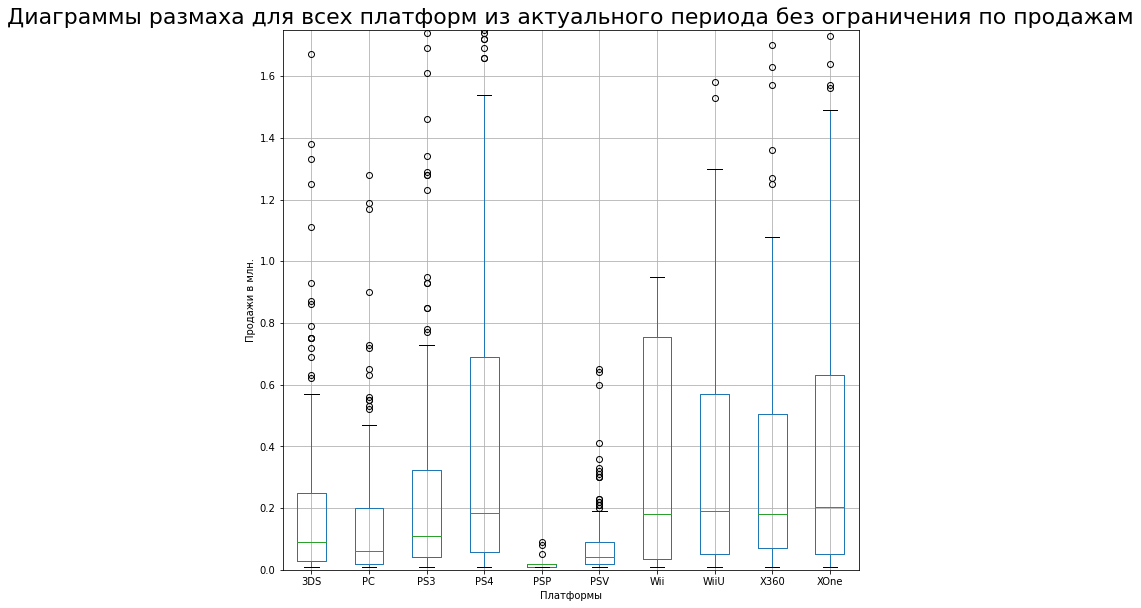

In [36]:
data_actual[['all_sales', 'platform']].boxplot('all_sales', by='platform', figsize=(10,10))
plt.ylim([0, 1.75])
plt.xlabel("Платформы")
plt.ylabel("Продажи в млн.")
plt.suptitle('')
plt.title('Диаграммы размаха для всех платформ из актуального периода без ограничения по продажам', fontsize=22)
plt.show()

<i>Вывод: наиболее продаваемые игры в актуальном периоде на платформах: `PS4`, `3DS`, `XO`, `WiiU`. Но  также можно заметить выбивающиеся значения, особенно их много у платформ `PS4`, `3DS`, `XO`. На графике также видно,что медианные значени `PS4`, `Wii`, `WiiU`, `X360`  и `XOne` находятся почти на одном уровне.<i>

**Проверим зависимость между оценками критиков и глобальными продажами в актуальный период:**

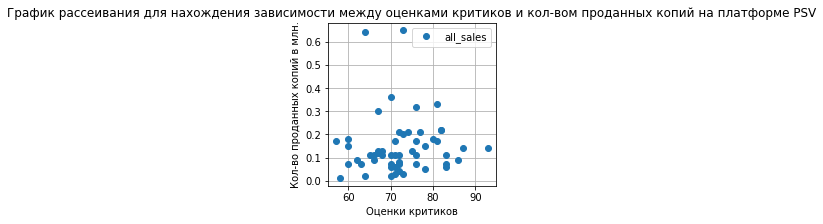

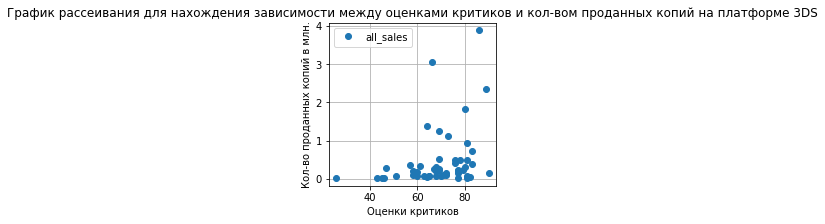

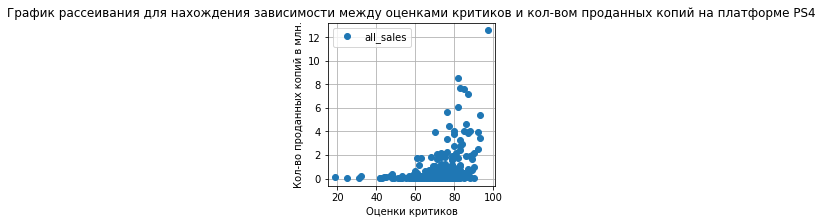

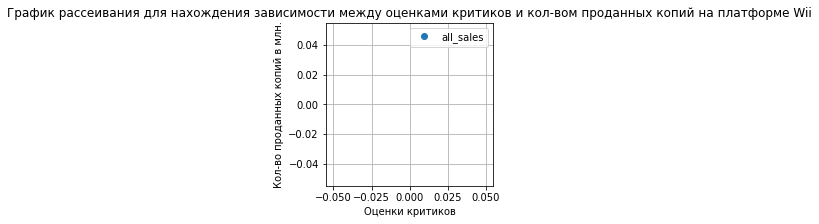

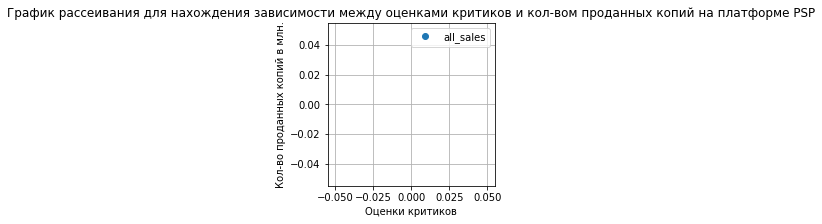

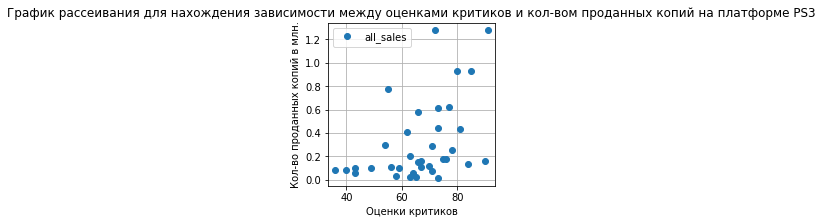

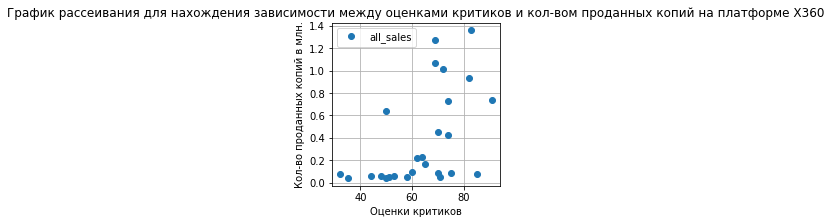

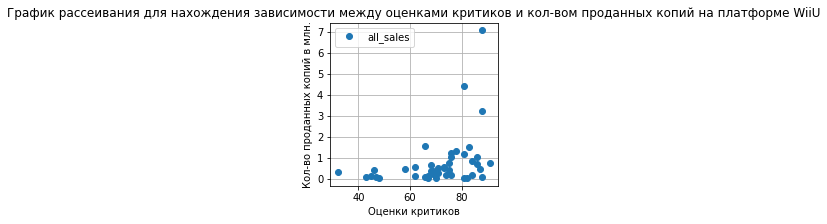

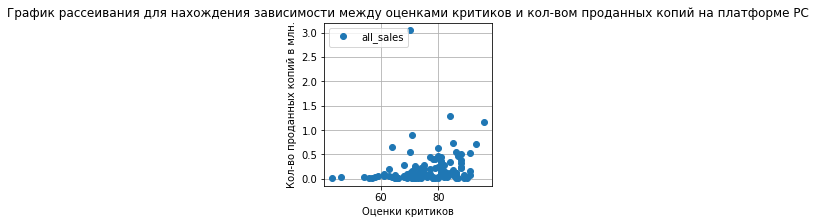

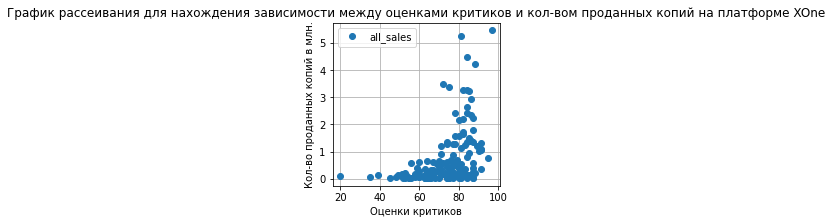

In [37]:
for i in actual_platform:
    data_actual.query('platform == @i and critic_score > -1').plot(x='critic_score', y='all_sales', style='o', grid=True, figsize=(3,3))
    plt.xlabel("Оценки критиков")
    plt.ylabel("Кол-во проданных копий в млн.")
    plt.title(f"График рассеивания для нахождения зависимости между оценками критиков и кол-вом проданных копий на платформе {i}")

In [38]:
for i in actual_platform:
    print(f"Платформа {i} имеет коэфф. корреляции: ",data_actual.query('platform == @i and critic_score > -1')['all_sales'].corr(data_actual.query('platform == @i and critic_score > -1')['critic_score']))
 

Платформа PSV имеет коэфф. корреляции:  0.04266490657009526
Платформа 3DS имеет коэфф. корреляции:  0.31411749286905105
Платформа PS4 имеет коэфф. корреляции:  0.40266141068104083
Платформа Wii имеет коэфф. корреляции:  nan
Платформа PSP имеет коэфф. корреляции:  nan
Платформа PS3 имеет коэфф. корреляции:  0.44657460493190704
Платформа X360 имеет коэфф. корреляции:  0.5257228356581523
Платформа WiiU имеет коэфф. корреляции:  0.370201412480884
Платформа PC имеет коэфф. корреляции:  0.17463413769350036
Платформа XOne имеет коэфф. корреляции:  0.42867694370333226


Каждая платформа показала разные результаты коэффициента корреляции Пирсона. Заметную корреляци можно выделить у платформы `X360`, но проанализировав диаграммы рассеивания, делаем вывод, что результат такой из-за того, что в акт. период продаж и отзывов критиков этой платформы было не так много. Тогда нас больше интересуют платформы с умеренной корреляцией: `XOne`, `PS4`, `PS3`. У платформ `Wii` и `PSP` данные отсуствуют, посмотрим в чем причина.

In [39]:
data_actual.query('platform == "Wii" and critic_score == -1').shape[0] == data_actual.query('platform == "Wii"').shape[0]

True

In [40]:
data_actual.query('platform == "PSP" and critic_score == -1').shape[0] == data_actual.query('platform == "PSP"').shape[0]

True

Делаем вывод, что оценок от критиков к двум этим платформам нет, поэтому и нет данных по корреляции.

**Проверим зависимость между оценками пользователей и глобальными продажами в актуальный период:**

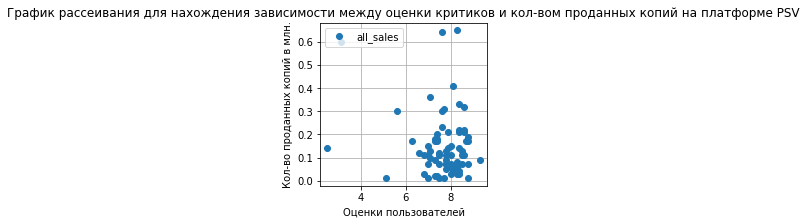

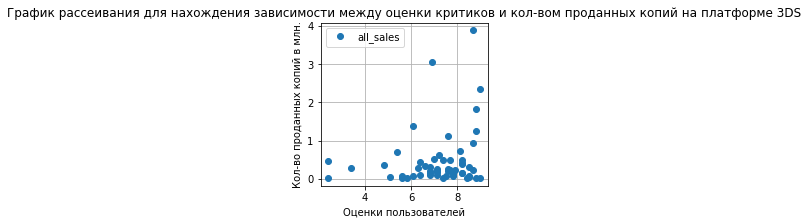

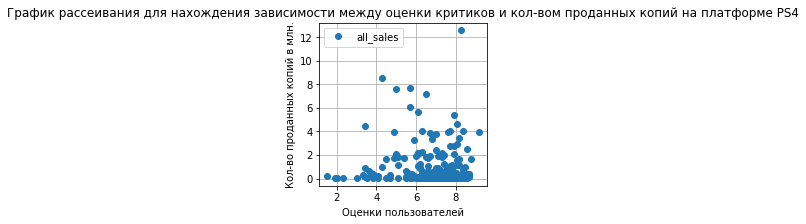

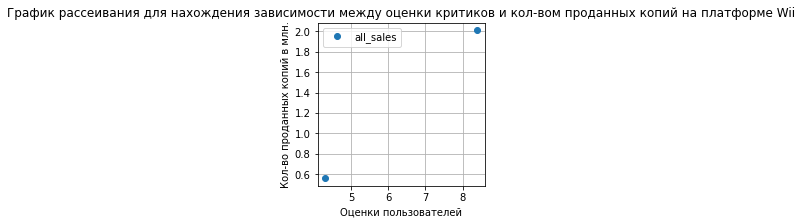

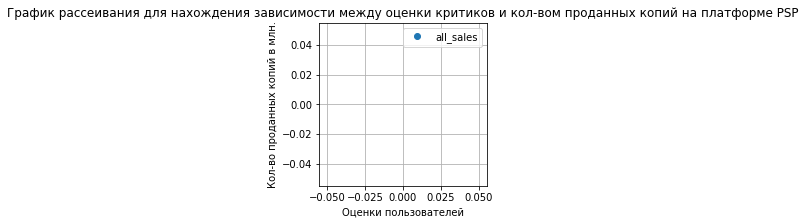

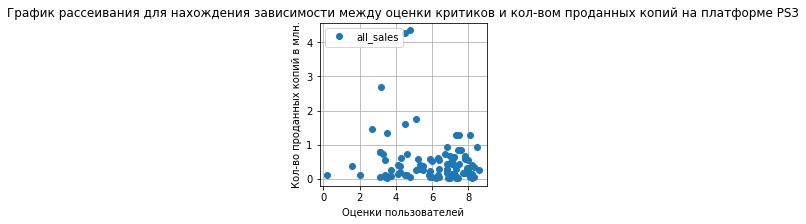

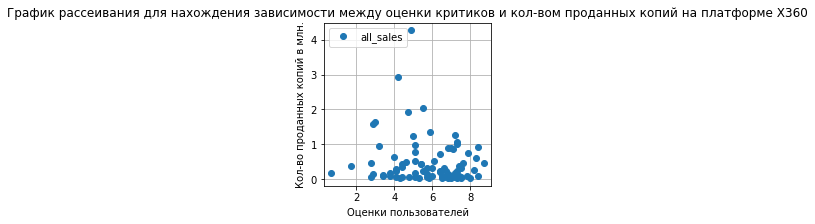

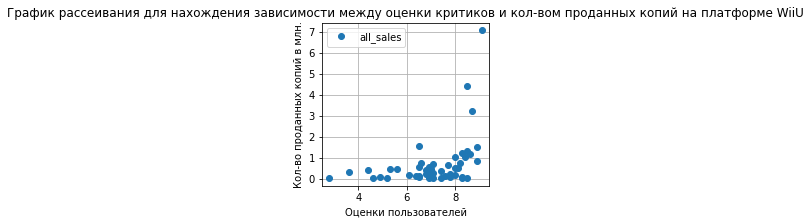

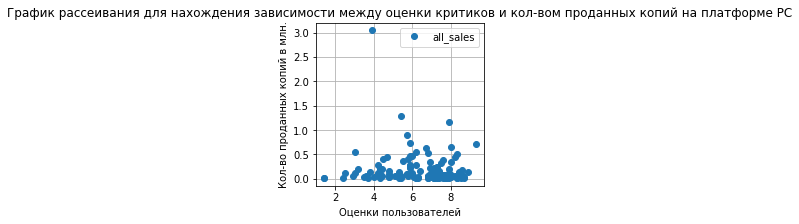

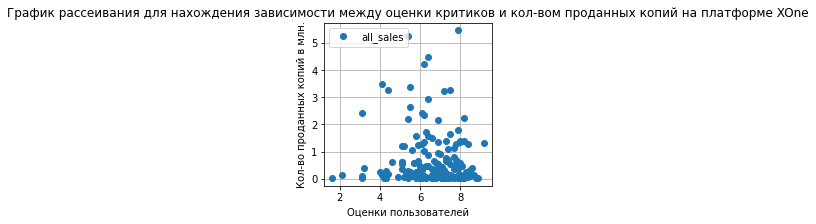

In [41]:
for i in actual_platform:
    data_actual.query('platform == @i and user_score > -1').plot(x='user_score', y='all_sales', style='o', grid=True, figsize=(3,3))
    plt.xlabel("Оценки пользователей")
    plt.ylabel("Кол-во проданных копий в млн.")
    plt.title(f"График рассеивания для нахождения зависимости между оценки критиков и кол-вом проданных копий на платформе {i}")

In [42]:
for i in actual_platform:
    print(f"Платформа {i} имеет коэфф. корреляции: ",data_actual.query('platform == @i and user_score > -1')['all_sales'].corr(data_actual.query('platform == @i and user_score > -1')['user_score']))
 

Платформа PSV имеет коэфф. корреляции:  -0.16845504978064446
Платформа 3DS имеет коэфф. корреляции:  0.2151932718527028
Платформа PS4 имеет коэфф. корреляции:  -0.040131589472697356
Платформа Wii имеет коэфф. корреляции:  1.0
Платформа PSP имеет коэфф. корреляции:  nan
Платформа PS3 имеет коэфф. корреляции:  -0.16676141347662116
Платформа X360 имеет коэфф. корреляции:  -0.138444570945665
Платформа WiiU имеет коэфф. корреляции:  0.4079264579217078
Платформа PC имеет коэфф. корреляции:  -0.07159665703472452
Платформа XOne имеет коэфф. корреляции:  -0.0703839280647581


Более заметная корреляция видна у платформы WiiU, но опять же такая ситуация в связи с малым кол-вом данных в актуальном периоде. Аналогично и с платформой Wii, малое кол-во данных не дает полной картины. Практически во всех других данных отрицательная корреляция, что говорит о том, что кол-во продаж не влияет от отзывов пользователей.

In [43]:
data_actual.query('platform == "PSP" and user_score == -1').shape[0] == data_actual.query('platform == "PSP"').shape[0]

True

И все продажи за акт. период у платформы PSP без отзыва от пользователя. Скорее всего, откуда взяты данные, в то время не было сбора отзывовю

**Посмотрим на общее распределение игр по жанрам:**

In [44]:
genre_sales = data_actual.pivot_table(index='genre', values='all_sales', aggfunc='median')
genre_sales.columns = ['median_sales']
genre_sales.sort_values(by='median_sales',  ascending=False)

,median_sales
genre,
Shooter,0.515
Sports,0.180
Platform,0.140
Fighting,0.125
Role-Playing,0.110
Simulation,0.100
Action,0.090
Misc,0.090
Racing,0.090


Text(0.5, 1.0, 'Распределение игр по жанрам')

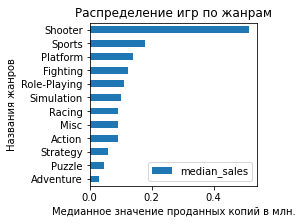

In [45]:
genre_sales.sort_values("median_sales").plot(kind='barh', figsize=(3,3))
plt.xlabel("Медианное значение проданных копий в млн.")
plt.ylabel("Названия жанров")
plt.title("Распределение игр по жанрам")

<i>Самый продаваемый жанр  `Shooter` - жанр компьютерной игры основан на стрельбе и уничтожении врагов. Немного устапает жанр `Sport`. <br>
    Самый непопулярный `Adventure`- жанр компьютерных игр, представляющий собой интерактивную историю с главным героем, управляемым игроком. Важнейшими элементами игры в жанре квеста являются собственно повествование и исследование мира. И также не самый популярный жанр - `Puzzle` <i>

**Вывод шага 3:<br>**
    Пик продаж был в 2007 году: расцвет компьютерных технологий. Можно заметить, что уже позже продажи идут на убыль, это связано с развитием интернета (много можно бесплатно найти и скачать во всемирной сети). <br>
    Мы выбрали 6 платформ игры на которых наиболее продаваемые.<br>
Большенство платформ имело разные временные рамки популярности, это связано с их появлением в мире. Мы выбрали для нас актуальный период 2014-2016 гг, так как в эти даты можно отследить, будет ли спад продаж в будущем 2017 году. Далее весь анализ будет проходить в эти года. Для этого создан отдельный DataFrame data_actual. <br>
Проанализировав данные через "ящик с усами" делаем вывод, что чаще всего игры продавались на платформу `PSP4`. После этого рассмотрели  построили диаграмму рассеивания и нашли корреляцию между кол-вом отзывов критиков/пользователей и кол-во глобальных продаж. Можно заметить умеренную закономерность между оценки критиков и кол-вом продаж на платформах `XOne`, `PS4`, `PS3`. На платформах `Wii` и `PSP` отзывы отсутствуют Если же рассматривать оценки пользователей, то здесь какой зависимости практически нет.<br>
**Результат этого анализа**: зависимости между отзывами пользователей и кол-вом продаж практически нет. Скорее всего это из-за субъективности оценок и раскрученности игры. А вот зависимость между оценками критиков и кол-вом продаж. Не всегда часто продаваемые игры имеют высокие рейтинги.<br>
Также провели анализ самых популярных жанров: самый популярный жанр: `Shooter`; самый непопулярный: `Adventure`.


## **Шаг . Составим портрет пользователя каждого региона (NA, EU, JP) за 2006-2011 годы**

**1) Продажи в Северной Америке:**

In [46]:
countries = data_actual.columns
countries = list(countries[4:7])
countries

['na_sales', 'eu_sales', 'jp_sales']

In [47]:
def country_portret(country, measure): #Функция для создания таблицы долей продаж среди трех стран по платформам и 
    portret= data_actual.pivot_table(index = measure, values = country, aggfunc='sum').sort_values(by=country, ascending=False).reset_index()
    if country == 'na_sales':
        name = 'Северная Америка'
    elif country == 'eu_sales':
        name = 'Европа'
    elif country == 'jp_sales':
        name = 'Япония'
    if measure == 'platform':
        portret.loc[6:,measure] = 'Другие платформы'
        print(f"Таблица самых популярных платформ (топ-5) в регионе: {name} ")
    elif measure == 'genre':
        portret.loc[6:,measure] = 'Другие жанры'
        print(f"Таблица самых популярных жанров (топ-5) в регионе: {name} ")
        
    portret.loc[6,country] =  portret.loc[6:,country].sum().round(2)
    portret = portret.iloc[0:7, :]
    portret ['fraction'] = portret[country] / portret[country].sum()
    display(portret)
    
    portret.plot(kind='pie', y='fraction', labels = portret[measure], autopct='%1.1f%%', legend=False, normalize=True)
    if measure == 'platform':
        plt.title(f'Доля продаж в зависимости от платформы в регионе: {name}')
    elif measure == 'genre':
        plt.title(f'Доля продаж в зависимости от жанра игры в регионе: {name}')
    plt.show()
    

Таблица самых популярных платформ (топ-5) в регионе: Северная Америка 


,platform,na_sales,fraction
0,PS4,98.61,0.347145
1,XOne,81.27,0.286102
2,X360,28.30,0.099627
3,3DS,22.64,0.079701
4,PS3,22.05,0.077624
5,WiiU,19.36,0.068155
6,Другие платформы,11.83,0.041646


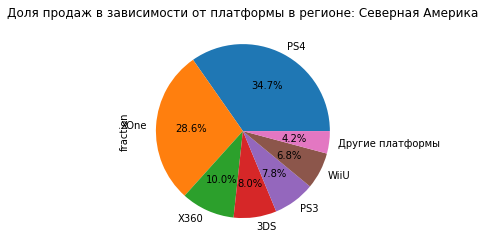

Таблица самых популярных жанров (топ-5) в регионе: Северная Америка 


,genre,na_sales,fraction
0,Shooter,79.02,0.278181
1,Action,72.53,0.255333
2,Sports,46.13,0.162395
3,Role-Playing,33.47,0.117827
4,Misc,15.05,0.052982
5,Fighting,12.43,0.043758
6,Другие жанры,25.43,0.089523


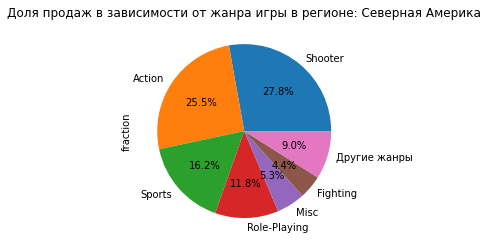

Таблица рейтингов в этом же регионе


,na_sales
rating,
M,96.42
-1,64.72
E,50.74
T,38.95
E10+,33.23


Таблица самых популярных платформ (топ-5) в регионе: Европа 


,platform,eu_sales,fraction
0,PS4,130.04,0.480420
1,XOne,46.25,0.170866
2,PS3,25.54,0.094355
3,PC,17.97,0.066388
4,3DS,16.12,0.059554
5,X360,15.49,0.057226
6,Другие платформы,19.27,0.071191


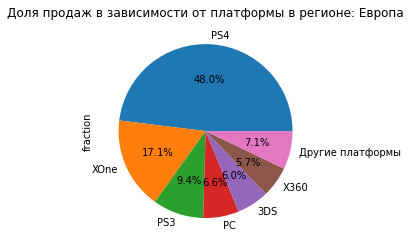

Таблица самых популярных жанров (топ-5) в регионе: Европа 


,genre,eu_sales,fraction
0,Action,74.68,0.275898
1,Shooter,65.52,0.242057
2,Sports,45.73,0.168945
3,Role-Playing,28.17,0.104071
4,Racing,14.13,0.052202
5,Misc,12.86,0.047510
6,Другие жанры,29.59,0.109317


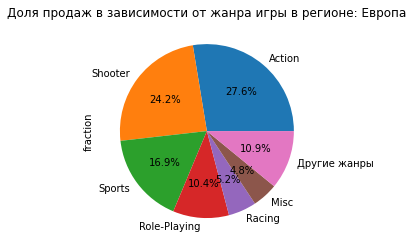

Таблица рейтингов в этом же регионе


,eu_sales
rating,
M,93.44
-1,58.95
E,58.06
T,34.07
E10+,26.16


Таблица самых популярных платформ (топ-5) в регионе: Япония 


,platform,jp_sales,fraction
0,3DS,44.24,0.475239
1,PS4,15.02,0.161349
2,PSV,14.54,0.156193
3,PS3,11.22,0.120529
4,WiiU,7.31,0.078526
5,PSP,0.36,0.003867
6,Другие платформы,0.40,0.004297


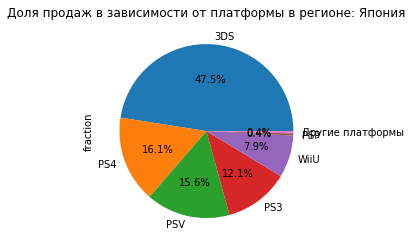

Таблица самых популярных жанров (топ-5) в регионе: Япония 


,genre,jp_sales,fraction
0,Role-Playing,31.16,0.334730
1,Action,29.58,0.317757
2,Fighting,6.37,0.068428
3,Misc,5.61,0.060264
4,Shooter,4.87,0.052315
5,Adventure,3.60,0.038672
6,Другие жанры,11.90,0.127833


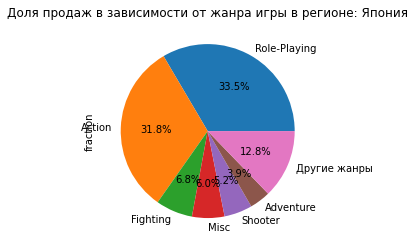

Таблица рейтингов в этом же регионе


,jp_sales
rating,
-1,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


In [48]:
for i in countries:
    country_portret(i, 'platform')
    country_portret(i, 'genre')
    print("Таблица рейтингов в этом же регионе")
    display(data_actual.pivot_table(index = 'rating', values = i , aggfunc='sum').sort_values(by= i, ascending=False).head())

**Портрет пользователя Северной Америки:<br>**
Пользователи из Америки предпочитают платформу `PS4` - почти 35% от всех продаж в Америке, большая часть играют в игры в жанрах Shooter, это около 28% региона, самый не популярный жанр  среди топ-5 -  `Fighting`. Рейтинг ESRB также влияет на кол-во продаж игр, больше всего продано игр с рейтингом `M`.<br>
**Портрет пользователя Европы:<br>**
Пользователи из Европы также предпочитают платформу `PS4` - здесь уже % от всех продаж 48 , большая часть играют в игры в жанрах `Action`, это около 28% региона, самый не популярный жанр  среди топ-5 -  `Misc`. Рейтинг ESRB также влияет на кол-во продаж игр как и в Америке, больше всего продано игр с рейтингом `M`.<br>
**Портрет пользователя Японии:<br>**
Портерт пользователя из Японии немного отличается, жители этого региона предпочитают `3DS` - это 48% от общих продаж в стране , большая часть играют в игры в жанрах `Role-Playing`, это около 33% региона, самый не популярный жанр  среди топ-5 -  `Adventure`. И если же смотреть рейтинг ESRB, то здесь большая часть их отсуствует, об этом нам говорит рейтинг -1.  В Японии маркировка содержания игры не требуется по закону, но большинство коммерческих издателей видеоигр принимают отраслевые саморегуляции. <br>

## Шаг. Проверим гипотезы:<br>
**-Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;<br>
-Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.<br>**

**Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC отличаются**

In [49]:
alpha = 0.01
results = st.ttest_ind(data_actual.query('platform == "XOne" and user_score > -1 ')['user_score'], data_actual.query('platform == "PC" and user_score > -1')['user_score'], alternative='two-sided')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: тогда средние пользовательские рейтинги платформ Xbox One и PC отличаются.')
else:
    print('Не отвергаем нулевую гипотезу: тогда  с большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий.')


p-value: 0.10450507919348415
Не отвергаем нулевую гипотезу: тогда  с большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий.


**Нулевая гипотеза:Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.<br>
Альтернативная: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

In [50]:
alpha = 0.01
results = st.ttest_ind(data_actual.query('genre == "Action" and user_score > -1 ')['user_score'], data_actual.query('genre == "Sports" and user_score > -1')['user_score'], alternative='two-sided')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.')
else:
    print('Не отвергаем нулевую гипотезу: тогда cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.')


p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


<i>1)Нулевую гипотезу взяли из вопроса, альтернативную построили на основе вопроса, так как не указано, что должно быть выше, все двухстороннюю.<br>
    2)Здесь с точностью наоборот.<i>

<div class="alert alert-block alert-danger">
<b>❌Комментарий ревьюера:</b> 
    
По обеим гипотезам результаты получили некорректные</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

**Вывод шага 6:**<br>
Средние пользовательские рейтинги платформ Xbox One и PC одинаковы;<br>
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

# Вывод проекта:

**Шаг 1**<br>
Открыли все CSV-файлы для проекта.<br>
**Шаг 2. Предобработка данных**<br>
Просмотрели информацию о них, избавились от дубликатов, искали пропущенные значения, год заменили на медианный, оценки пользователей/критиков заменили на `-1`, что дальше учитывали. Перевели столбцы с годом и оценкой критика в целочисленный формат, оценка пользователя стала в формате с плавающей точкой. Также заметили значени `tbd` в оценке пользователя - что является другими данными, также заменили на `-1`.<br> 
**Шаг 3. Исследовательский анализ данных**<br>
Определили, что самый пик продаж приходится на 2007 год. Это связано с расцветом технологий, но далее можно заметить, что идет спат продаж, это связано с легким доступом в интернете (бесплатное скачивание).  <br>
Посмотрев на то, как меняются продажи в зависимости от платформы, выделили среди них топ-6. Больше всего продаж среди игр на платформе `PS2`.<br>
После этого построили графики по этим 6 платформам. Средняя продолжительность "жизни" платформы 10 лет. Большинство платформ были популярны в разные годы, отсюда и различные временные промежтки. Но можно заметить, что платформа `DS` и `PS2` имели свои пики продаж в одном году, что может говорить о их сильно конкуренции.<br>
Для последующего анализа возьмем данные за 2014 - 2016 год (так мы сможем выделить успешные платформы, которые на 2017 год будут находиться в периоде финального роста или выйдут на плато). Построив сводную гистограмму виделили топ-3 платформ:`PS4`, `Xone` (спада продаж нет). <br>
Для каждой платформы из списка популярных платформ посмотрели диаграммы размаха и выбрали ниболее продаваемые платформы `PS4`, `3DS`, `XOne`, `WiiU`. <br>
Далее построили графики рассеивания и нашли корреляцию между кол-вом продаж и оценкой критиков/пользователей. Более заметная зависимость наблюдается при рассмотрении оценок критиков - так платформы с умеренной корреляцией: `XOne`, `PS4`, `PS3`.  А при исследовании влияния оценок пользователей зависимости почти нет. Скорее всего это из-за субъективности оценок и раскрученности игры. Не всегда часто продаваемые игры имеют высокие рейтинги.<br>
Самый продаваемый жанр `Shooter` - жанр компьютерной игры основан на стрельбе и уничтожении врагов. Немного устапает жанр Sport.<br>
Самый непопулярный `Adventure`- жанр компьютерных игр, представляющий собой интерактивную историю с главным героем, управляемым игроком. Важнейшими элементами игры в жанре квеста являются собственно повествование и исследование мира. И также не самый популярный жанр - `Puzzle`.<br>
**Шаг 4. Портреты пользователей каждого региона.**<br>
**Портрет пользователя Северной Америки:<br>**
Пользователи из Америки предпочитают платформу `PS4` - почти 35% от всех продаж в Америке, большая часть играют в игры в жанрах Shooter, это около 28% региона, самый не популярный жанр  среди топ-5 -  `Fighting`. Рейтинг ESRB также влияет на кол-во продаж игр, больше всего продано игр с рейтингом `M`.<br>
**Портрет пользователя Европы:<br>**
Пользователи из Европы также предпочитают платформу `PS4` - здесь уже % от всех продаж 48 , большая часть играют в игры в жанрах `Action`, это около 28% региона, самый не популярный жанр  среди топ-5 -  `Misc`. Рейтинг ESRB также влияет на кол-во продаж игр как и в Америке, больше всего продано игр с рейтингом `M`.<br>
**Портрет пользователя Японии:<br>**
Портерт пользователя из Японии немного отличается, жители этого региона предпочитают `3DS` - это 48% от общих продаж в стране , большая часть играют в игры в жанрах `Role-Playing`, это около 33% региона, самый не популярный жанр  среди топ-5 -  `Adventure`. И если же смотреть рейтинг ESRB, то здесь большая часть их отсуствует, об этом нам говорит рейтинг -1.<br>
Портреты пользователей из Америки и Европы очень схожи, это может быть обусловлено схожими стилями жизни. А вот в портрете пользователя из Японии можно заметить явные отличия, что также связано со менталитетом.  В Японии маркировка содержания игры не требуется по закону, но большинство коммерческих издателей видеоигр принимают отраслевые саморегуляции.<br>
**Шаг 5. Проверка гипотез:**<br>
Средние пользовательские рейтинги платформ `Xbox` `One` и `PC` одинаковы;<br>
Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные, этот факт подтверждается в шаге 3, где мы смотрели распределение игр по жанрам.<br>


# Общие рекомендации:<br> 
Лучше всего обратить внимание жанры игры `Shooter` и `Sport` вне зависимости от региона, во всех трех представленных странах показатели этих жанров велики. Самая популярная платформа `PS4`, пусть в Японии она и не на первом месте, но занимает почетное второе. Также можно обратить внимание на платформу `3DS`, она есть в топе-5 всех трёх стран,  и на платформу `XOne`. Рейтинги игр побольше части не заполнены. Но можно выделить что более восстребованы игры с категорией `М`.

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> 
    
Хороший резюмирующий вывод!


**Хочу обратить твое внимание на то, что после исправления замечаний в некоторых пунктах исследования могут измениться результаты, поэтому нужно будет подкорректировать выводы.**</div>

<div class="alert alert-block alert-warning">
<b>🔁Комментарий ревьюера:</b> 
    
Все-таки лучше добавить рекомендации отделу маркетинга для проведения рекламной кампании в 2017 году. На какие платформы и жанры следует обратить внимание? Стоит ли учитывать оценки пользователей и критиков, возрастные рейтинги?
    
</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>